In [13]:
import numpy as np
import dedalus.public as d3
import logging
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm
logger = logging.getLogger(__name__)
OMP_NUM_THREADS = 1

798190.4314218217


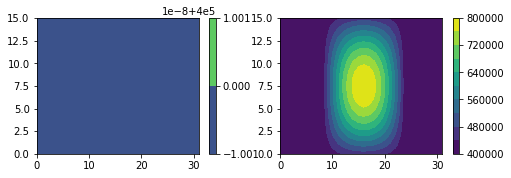

In [14]:
# Simulation units
meter = 1 
second = 1
hour = 3600
day = 24 * 3600

# Parameters
Nphi = 32
Ntheta = 16
dealias = 3/2
R = 8.2e7 * meter
H = 4e5 * meter # nightside height
tau_drag = 10 * day
tau_rad = 0.1 * day
Omega = 3.2e-5 / second
nu = 1e-3 * meter**2 / second / 32**2 # Hyperdiffusion matched at ell=32
g = 10 * meter / second**2
timestep = 1000 * second
stop_sim_time = 30 * day
dtype = np.float64

def plot(mat):
    phi = np.linspace(0, 2*np.pi, Nphi)
    theta = np.linspace(0, np.pi, Ntheta)
    phi, theta = np.meshgrid(phi, theta)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Set the aspect ratio to 1 so our sphere looks spherical
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.coolwarm(mat))
    # Turn off the axis planes
    #ax.set_axis_off()
    plt.show()

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
h_eq = dist.Field(name='h_eq', bases=basis)

# Substitutions
zcross = lambda A: d3.MulCosine(d3.skew(A))
hypdiff = lambda A: d3.lap(d3.lap(d3.lap(A)))
Q = (h_eq - h)/tau_rad
R = - u / h * (Q + abs(Q)) / 2

# Initial conditions: 
phi, theta = dist.local_grids(basis)
del_h_eq = 1 * H
phi0, theta0, sigxsq, sigysq = np.pi, 2 * np.pi / 4, 1, 1
#h_eq['g'] = hmax * np.exp(-(phi - phi0)**2 / 2 / sigxsq + -(theta - theta0)**2 / 2 / sigysq)
h_var = np.cos(phi - phi0) * np.cos(theta - theta0)
h_eq['g'] = H + del_h_eq * (h_var + abs(h_var))/2
h['g'] = H

print(h_eq['g'].max())
plt.figure(figsize=(8,2.5))
plt.subplot(1,2,1)
plt.contourf(h['g'].T) # initial condition
cbar = plt.colorbar(location='right')
cbar.formatter.set_powerlimits((0, 0))
plt.subplot(1,2,2)
plt.contourf(h_eq['g'].T,levels=10) # forcing
cbar = plt.colorbar(location='right')
cbar.formatter.set_powerlimits((0, 0))

2024-05-07 10:38:41,854 subsystems 0/1 INFO :: Building subproblem matrices 1/15 (~7%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s
2024-05-07 10:38:41,871 subsystems 0/1 INFO :: Building subproblem matrices 2/15 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2024-05-07 10:38:41,903 subsystems 0/1 INFO :: Building subproblem matrices 4/15 (~27%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2024-05-07 10:38:41,935 subsystems 0/1 INFO :: Building subproblem matrices 6/15 (~40%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+01/s
2024-05-07 10:38:41,966 subsystems 0/1 INFO :: Building subproblem matrices 8/15 (~53%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+01/s
2024-05-07 10:38:41,998 subsystems 0/1 INFO :: Building subproblem matrices 10/15 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+01/s
2024-05-07 10:38:42,030 subsystems 0/1 INFO :: Building subproblem matrices 12/15 (~80%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+01/s
2024-05-07 10:38:42,062 subsystems 0/1 INFO :: Building subproblem matrices

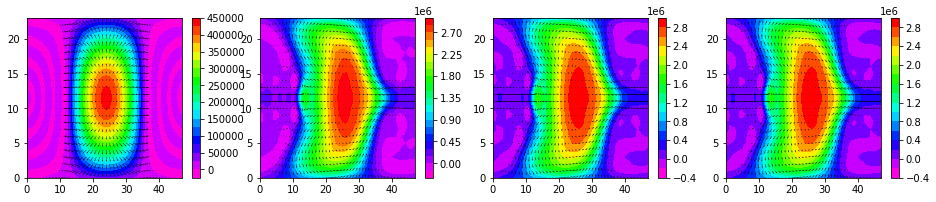

In [15]:
# Problem
problem = d3.IVP([u, h], namespace=locals())
# problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = 0") # dt() is partial derivative, linear
# problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = (h_eq - h)/tau_rad - div(h*u) ")
problem.add_equation("dt(u) + nu*hypdiff(u) + g*grad(h) + 2*Omega*zcross(u) = R - u@grad(u) - u/tau_drag") # nonlinear
problem.add_equation("dt(h) + nu*hypdiff(h) = Q - div(h*u) ")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
#snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
#snapshots.add_task(h, name='height')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(0.5*(u@u), name='KinE') # kinetic energy

# Plotting
fig = plt.figure(figsize=(16, 10))#, nrows=2, ncols=5, constrained_layout=True)

# Main loop
n = 0; kin = []; Time = []
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        t = solver.sim_time
        kin.append(flow.grid_average('KinE'))
        Time.append(t)
        #if (solver.iteration-1) % 30 == 0:
            #logger.info('Iteration=%i, Time=%e, dt=%e, max_h=%e' %(solver.iteration, solver.sim_time, timestep, h['g'].max()))
        if solver.sim_time > n * solver.stop_sim_time / 4:
            print(solver.iteration)
            # plt.figure(figsize=(5,2.5))
            plt.subplot(3,4,n+1)
            plt.contourf((h['g'].T - H)*g,cmap='gist_rainbow_r',levels=20)
            #plt.clim(-1,hmax)
            cbar = plt.colorbar(location='right')
            cbar.formatter.set_powerlimits((0, 0))
            plt.quiver(u['g'][0].T,-u['g'][1].T)
            n = n + 1 
        
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
plt.savefig('shallow.png')
# plt.figure(figsize=(2.5,2.5))
# plt.plot(Time/day,kin)
# plt.xlabel("Time"); plt.ylabel("Kinetic Energy")

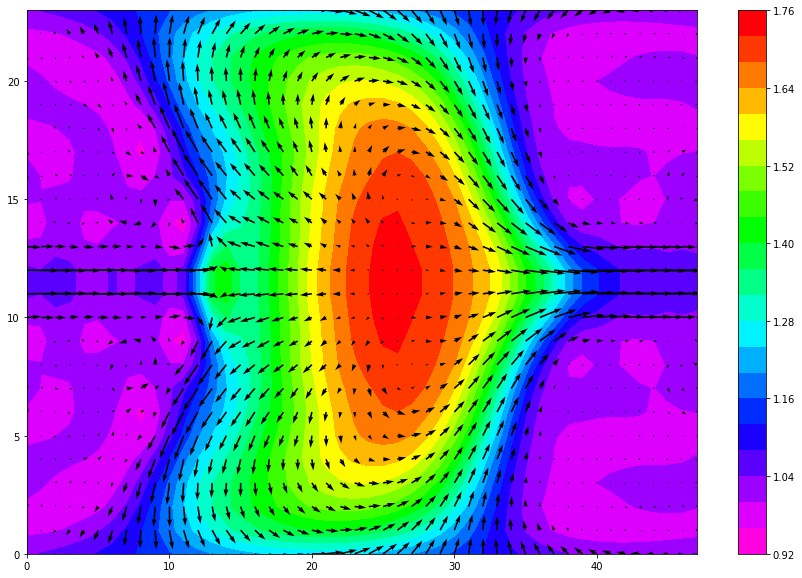

In [19]:
plt.figure(figsize=(15,10))
plt.contourf(h['g'].T/H,cmap='gist_rainbow_r',levels=20) # plot geopotential field
cbar = plt.colorbar(location='right')
cbar.formatter.set_powerlimits((0, 0))
plt.quiver(u['g'][0].T,-u['g'][1].T)